# Drag on a Fast Sheet

Text retrieved from [1]: *A fast sheet ($v_{sheet} \gg v_{th}$) moving through the plasma is expected to feel a constant drag given by* [2]:

$$
\frac{dv}{dt} = -\frac{\omega_p^2 \delta}{2} .
$$

*This drag is independent of the velocity of the sheet and is caused by the excitation
of a electrostatic wake on the rear of the fast sheet, i.e. the sheet transfers energy to
the electrostatic wake*

In this notebook we will demonstrate this behavior for the case of fast sheets moving inside a thermal plasma ($v_{th} \neq 0$) and, for illustration purposes, the case of a single fast sheet crossing a system of sheets at rest ($v_{th} = 0$). We will be using both the Sheet Model and the GNS.


#### References
[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Section 6.5 <br>
[2] J. Dawson, Phys. Fluids 5.4 (1962) - See pp. 451

In [1]:
import os
import jax
import sys
import numpy as np

from pathlib import Path
from tqdm.auto import tqdm

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt

sys.path.append('../..')
from sheet_model.synchronous import SyncSheetModel
from sheet_model.utils import get_x_eq, get_dx_eq, get_Efield
from gns.preprocess import init_GNS_as_SM
from gns.simulator import SMGNS

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## $v_{th} = 0$

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

n_guards != 0 ignored for periodic boundaries


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

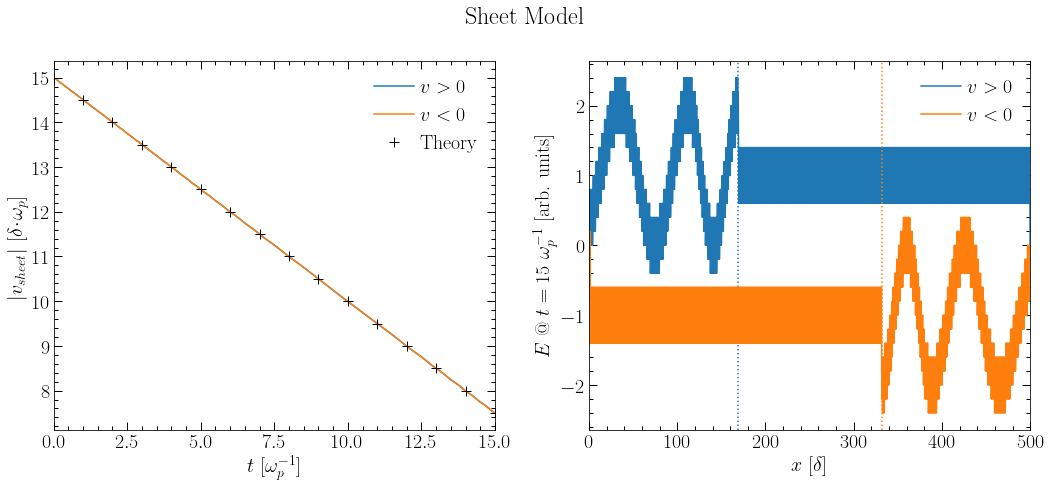

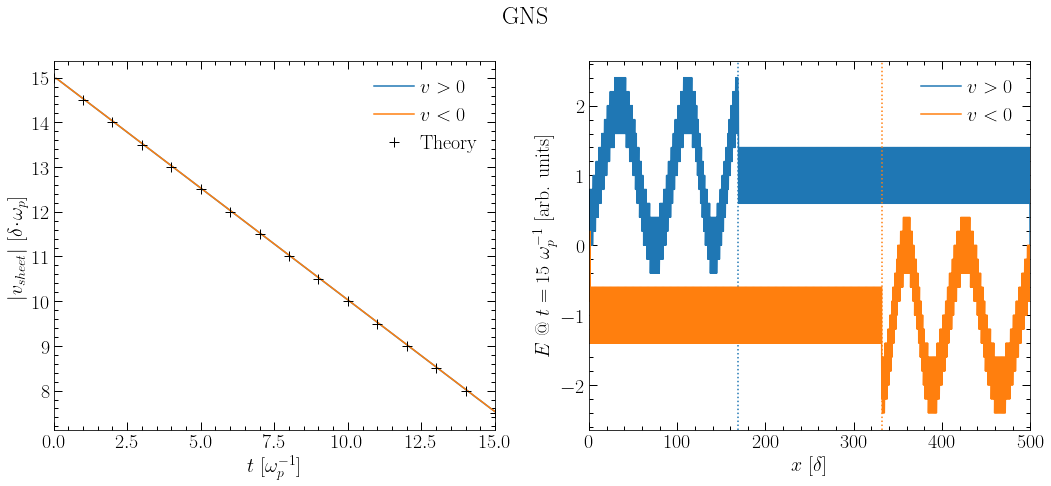

In [2]:
# ----------------------------------
# Sheet Model Simulation Options

opt = {
    'n_guards' : 2, # number of guards
    'n_sheets' : 500, # number of sheets
    'dt' : 1e-1, # simulation dt [1/w_p]
    'boundary' : 'periodic', # boundary type (periodic or reflecting)
    'n_it_crossings' : 4, # number of iterations used to solve crossings
    'track_sheets': True,
    'L': 1
}

t_max = 15
dt_undersample = 1

dx_eq = get_dx_eq(opt['n_sheets'], opt['L']) 
x_eq = get_x_eq(opt['n_sheets'], opt['L'])


# ----------------------------------
# Sheet Model

sim = SyncSheetModel(**opt)

# ----------------------------------
# GNSimulator

model_folder = Path(f'../../models/final/dt1e-1/4/')
gns = SMGNS(model_folder, opt['boundary'], verbose=False)

# ----------------------------------
# Fast Sheet Velocity

v_max = 15

# ----------------------------------
# Figures

fig_sm, ax_sm = plt.subplots(1,2, figsize=(15,7))
fig_gns, ax_gns = plt.subplots(1,2, figsize=(15,7))

fig_sm.suptitle('Sheet Model')
fig_gns.suptitle('GNS')

for v_pos in [True, False]:
    
    x_0 = x_eq.copy() 
    v_0 = np.zeros(opt['n_sheets'])
    
    if v_pos:
        v_0[0] = v_max * dx_eq    
    else:
        v_0[0] = - v_max * dx_eq
        
    # Sheet model simulation
    X, V, _, _ = sim.run_simulation(x_0=x_0,
                                    v_0=v_0,
                                    t_max=t_max,
                                    dt_undersample=dt_undersample)

    sim_undersample = int(gns.dt_train/(opt['dt']*dt_undersample))
    V = V[::sim_undersample]
    
    x_0, v_0, _, _ = init_GNS_as_SM(x_0, v_0, x_eq, gns, n_guards=opt['n_guards'])
    
    # GNS simulation
    X_gns, V_gns, _, _ = gns.pred_rollout(x_0, 
                                          v_0,
                                          x_eq,
                                          t_max=t_max,
                                          track_sheets=True,
                                          n_guards=5,
                                          np_=np)


    
    # ----------------------------------
    # Plot Fast-Sheet Velocity
    
    V = np.abs(V)
    V_gns = np.abs(V_gns)
    
    t = np.arange(len(V)) * gns.dt_train
    v_teor = np.max(V) / dx_eq - t/2
    
    v_sheet_gns = V_gns[:,0] / dx_eq
    v_sheet = V[:,0] / dx_eq
  
    label = '$v > 0$' if v_pos else '$v < 0$'
    color = 'tab:blue' if v_pos else 'tab:orange'

    ax_gns[0].plot(t, v_sheet_gns, '-', color=color, ms=10, label=label)
    ax_sm[0].plot(t, v_sheet, '-', color=color, ms=10, label=label)
    
    # ----------------------------------
    # Plot Electric Field
    
    ax_sm[1].plot(*get_Efield(X[-1], nx=5*opt['n_sheets']+1, dx_eq=dx_eq, L=opt['L']), color=color, label=label)
    ax_gns[1].plot(*get_Efield(X_gns[-1], nx=5*opt['n_sheets']+1, dx_eq=dx_eq, L=opt['L']), color=color, label=label)
    ax_sm[1].axvline(X[-1][0] / dx_eq, color=color, ls=':')
    ax_gns[1].axvline(X[-1][0] / dx_eq, color=color, ls=':')

ax_gns[0].plot(t[::10], v_teor[::10], '+', ms=10, label='Theory', color='black', linewidth=3)
ax_sm[0].plot(t[::10], v_teor[::10], '+', ms=10, label='Theory', color='black', linewidth=3)

for a in [ax_gns[0], ax_sm[0]]:
    a.set_xlabel('$t \ [\omega_p^{-1}]$')
    a.set_ylabel('$|v_{sheet}| \ [\delta\!\cdot\!\omega_p]$')
    a.legend()    
    a.set_xlim(0, t_max)
    
for a in [ax_gns[1], ax_sm[1]]:
    a.set_xlabel('$x \ [\delta]$')
    a.set_ylabel(f'$E$ @ $t = {t_max}~\omega_p^{{-1}}$  [arb. units]')
    a.legend()    
    a.set_xlim(0, opt['n_sheets'])

fig_sm.tight_layout()
fig_gns.tight_layout()

fig_sm.savefig('../img/fast_sheet_vth0_sm')
fig_gns.savefig('../img/fast_sheet_vth0_gns')

plt.show()

In the plots above, you can observe not only the fast sheet velocity decreasing as expected (left) but also the generation of a wake on its rear (right).

## $v_{th} \neq 0$

For the case where  $v_{th} \neq 0$, only the average drag (over sheets) is expected to follow the theoretical curve. We obtain this average over multiple equivalent simulations of a fast sheet moving over a (small) system of sheets with initial velocities sampled from a thermal distribution. This is different from the diagnostic originally implemented by Dawson [2], where he instead tracks fast sheets which are self-consistently accelerated inside a thermal plasma.

**Note**: Running the code below will take some minutes due to  the Sheet Model simulations. If you only want to use the GNS, consider commenting the Sheet Model simulation call.

In [3]:
# ----------------------------------
# Sheet Model Simulation Options

opt = {
    'n_guards' : 10, # number of guards
    'n_sheets' : 100, # number of sheets
    'dt' : 1e-1, # simulation dt [1/w_p]
    'boundary' : 'periodic', # boundary type (periodic or reflecting)
    'n_it_crossings' : 2, # number of iterations used to solve crossings
    'track_sheets': True,
    'L': 1
}

t_max = 5
dt_undersample = 1

dx_eq = get_dx_eq(opt['n_sheets'], opt['L']) 
x_eq = get_x_eq(opt['n_sheets'], opt['L'])

# ----------------------------------
# Sheet Model
sim = SyncSheetModel(**opt)

# ----------------------------------
# GNSimulator

model_folder = Path(f'../../models/final/dt1e-1/4/')
gns = SMGNS(model_folder, opt['boundary'], verbose=False)
sim_undersample = int(gns.dt_train / (opt['dt'] * dt_undersample))

# ----------------------------------
# Initial Values
v_th = 5 * dx_eq
x_0 = x_eq.copy()

# number of different simulations
n_sim = 1000
    
results = dict()

for v_fs in [2.5*v_th, 3*v_th, 3.5*v_th]:
    
    print(f'v_fs: {v_fs/dx_eq} [dx_eq w_p^-1]')
    
    results[v_fs] = dict()
    
    for v_pos in [True, False]:    

        v_fs_sm = []
        v_fs_gns = []

        
        np.random.seed(42)
        
        for _ in tqdm(range(n_sim)):    

            # use thermal plasma
            x_0_fs = np.copy(x_0)
            x_eq_0_fs = np.copy(x_eq)
            v_0_fs = np.random.normal(0, v_th, opt['n_sheets'])

            # introduce fast sheet
            v_0_fs[0] = v_fs if v_pos else -v_fs
    
            # Sheet Model simulation
            # THEY TAKE A LOOOOONG TIME
            _, V_sm, _, _ = sim.run_simulation(x_0=x_0_fs,
                                               v_0=v_0_fs,
                                               x_eq_0=x_eq_0_fs,
                                               t_max=t_max,
                                               dt_undersample=dt_undersample,
                                               verbose=False)


            V_sm = V_sm[::sim_undersample]

            # GNS simulation
            _, V_gns, _, _ = gns.pred_rollout(x_0_fs, 
                                              v_0_fs,
                                              x_eq_0_fs,
                                              t_max=t_max,
                                              verbose=False,
                                              track_sheets=True,
                                              np_=np)

            # store fast sheet velocity evolution
            v_fs_sm.append(np.abs(V_sm[:,0])/dx_eq)
            v_fs_gns.append(np.abs(V_gns[:,0]/dx_eq))
            
        results[v_fs][v_pos] = {'sm': np.array(v_fs_sm),
                                'gns': np.array(v_fs_gns)}

v_fs: 12.5 [dx_eq w_p^-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

v_fs: 15.000000000000002 [dx_eq w_p^-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

v_fs: 17.5 [dx_eq w_p^-1]


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Sheet Model Results

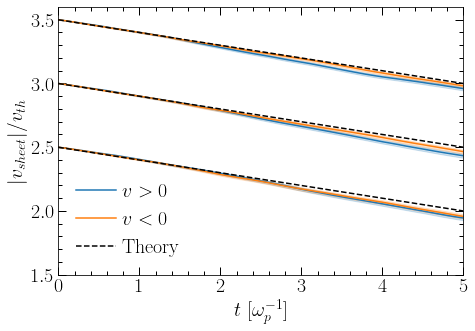

In [4]:
plt.figure()

for i_v_fs, v_fs in enumerate(results):
    for v_pos, v in results[v_fs].items():
    
        label = ('$v > 0$' if v_pos else '$v < 0$') if i_v_fs == 0 else None
        color = 'tab:blue' if v_pos else 'tab:orange'

        t = np.arange(v['sm'].shape[-1]) * opt['dt'] * dt_undersample
        
        y = np.mean(v['sm'], axis=0)/v_th*dx_eq
        y_std = np.std(v['sm'],axis=0)/np.sqrt(len(v['gns']))/v_th*dx_eq
        
        plt.plot(t,  y, '-', color=color, label=label)
        
        plt.fill_between(t,
                         y - y_std,
                         y + y_std,
                         color=color,
                         alpha=0.2)
        
    plt.plot(t, (v_fs/v_th - t/2/v_th*dx_eq), '--k', lw=1.5, label='Theory' if i_v_fs==0 else None)
    
plt.xlabel('$t \ [\omega_p^{-1}]$')
plt.ylabel('$|v_{sheet}| / v_{th}$')
plt.legend(framealpha=0.2) 
plt.xlim(0, t_max)
plt.ylim(1.5,3.6)
plt.tight_layout()
plt.savefig('../img/fast_sheet_sm.pdf')
plt.show()

### GNS Results

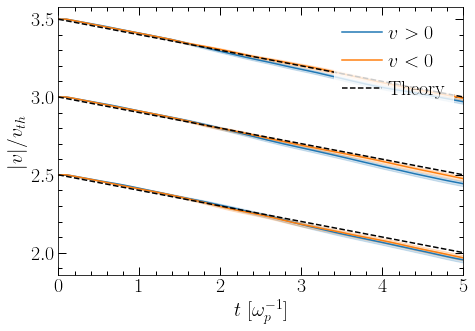

In [5]:
plt.figure()

for i_v_fs, v_fs in enumerate(results):
    for v_pos, v in results[v_fs].items():
    
        label = ('$v > 0$' if v_pos else '$v < 0$') if i_v_fs == 0 else None
        color = 'tab:blue' if v_pos else 'tab:orange'

        t = np.arange(v['gns'].shape[-1]) * gns.dt_train 
        
        y = np.mean(v['gns'], axis=0)/v_th*dx_eq
        y_std = np.std(v['gns'],axis=0)/np.sqrt(len(v['gns']))/v_th*dx_eq
        
        plt.plot(t,  y, '-', color=color, label=label)
        
        plt.fill_between(t,
                         y - y_std,
                         y + y_std,
                         color=color,
                         alpha=0.2)
        
    plt.plot(t, (v_fs/v_th - t/2/v_th*dx_eq), '--k', lw=1.5, label='Theory' if i_v_fs==0 else None)
    
plt.xlabel('$t \ [\omega_p^{-1}]$')
plt.ylabel('$|v| / v_{th}$')
plt.legend(framealpha=0.8, loc='upper right') 
plt.xlim(0, t_max)
#plt.ylim(1.6,3.6)
plt.tight_layout()
plt.savefig('../img/fast_sheet_gns.pdf')
plt.show()